In [52]:
import numpy as np
import pandas as pd
import matplotlib.cm
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr

import matplotlib.lines as mlines
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
import time

import findspark
findspark.init()

from geopy.distance import geodesic

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import count, sum, avg, udf, to_timestamp, date_trunc
from pyspark.sql.functions import year, month, hour, dayofweek
from pyspark.sql.types import FloatType, StructType, IntegerType, StringType, DoubleType, StructField, TimestampType, DateType

import random

spark1 = SparkSession.builder.appName("CB").getOrCreate()

import datetime as dt
print("modules imported")

randomSeed = 1984

pathWeather = "/users/sajudson/Dropbox/WPI/DS504/project/weather/"
pathData = "/users/sajudson/Dropbox/WPI/DS504/project/data/"
pathFigure = "/users/sajudson/Dropbox/WPI/DS504/project/figures/"


plt.style.use('ggplot')

modules imported


In [53]:

#Use NYC weather data for both data sets
weatherRaw = "NYC"+'weatherRaw'
weatherFeatures = "NYC"+'weatherFeatures'

file_type = 'csv'

In [77]:
t0= time.time()
#weatherDataFileName = 'weather_nyc_metblue'
weatherDataFileName = 'weather_nyc'
weatherDataFileExt = ".csv"

#create weather schema
weatherSchema0 = StructType([StructField('dt', IntegerType(), False),
                            StructField('dt_iso', StringType(), False),
                            StructField('city_id', IntegerType(), False),
                            StructField('city_name', StringType(), True),
                            StructField('lat', DoubleType(), True),
                            StructField('lon', DoubleType(), True),
                            StructField('temp', DoubleType(), False),
                            StructField('temp_min', DoubleType(), True),
                            StructField('temp_max', DoubleType(), True),
                            StructField('pressure', IntegerType(), True),
                            StructField('sea_level', IntegerType(), True),
                            StructField('grnd_level', IntegerType(), True),
                            StructField('humidity', DoubleType(), True),
                            StructField('wind_speed', DoubleType(), True),
                            StructField('wind_deg', IntegerType(), True),
                            StructField('rain_1h', DoubleType(), True),
                            StructField('rain_3h', DoubleType(), True),
                            StructField('rain_24h', DoubleType(), True),
                            StructField('rain_today', DoubleType(), True),
                            StructField('snow_1h', DoubleType(), True),
                            StructField('snow_3h', DoubleType(), True),
                            StructField('snow_24h', DoubleType(), True),
                            StructField('snow_today', DoubleType(), True),
                            StructField('clouds_all', IntegerType(), True),
                            StructField('weather_id', IntegerType(), False),
                            StructField('weather_main', StringType(), False),
                            StructField('weather_description', StringType(), False),
                            StructField('weather_icon', StringType(), False)
                           ])

weatherSchema1 = StructType([StructField('year', IntegerType(), False),
                            StructField('month', IntegerType(), False),
                            StructField('day', IntegerType(), False),
                            StructField('hour', IntegerType(), False),
                            StructField('minute', IntegerType(), False),
                            StructField('temp', DoubleType(), False),
                            StructField('humidity', DoubleType(), True),
                            StructField('total_precip', DoubleType(), True),
                            StructField('snow', DoubleType(), True),
                            StructField('cloud_cover', DoubleType(), True),
                            StructField('wind_speed', DoubleType(), True),
                            StructField('wind_direction', DoubleType(), True),
                            StructField('wind_gust', DoubleType(), True),
                           ])




# CSV options
infer_schema = "false"
first_row_is_header = "true"
delimiter = ","
#delimiter = ";"

# The applied options are for CSV files. For other file types, these will be ignored.
weather = spark1.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .schema(weatherSchema0) \
  .load(pathWeather+weatherDataFileName+weatherDataFileExt
)
print("weather file loaded",time.time()-t0)
#convert dt_iso into spark timestamp
@udf('string')
def trimDateTimeUTC(d):
    return (d[:-10])

from pyspark.sql.functions import round, concat, col, lit
from pyspark.sql.types import TimestampType


dateConcat = concat(col("year"), lit("-"), col("month"),lit("-"), col('day'))
timeConcat = concat(col("hour"), lit(":"), col("minute"),lit(':00'))
datetimeConcat = concat(dateConcat,lit(" "),timeConcat)

#weather = weather.withColumn("datetime", to_timestamp(datetimeConcat,"yyyy-MM-dd HH:mm:ss").cast("timestamp"))
weather = weather.withColumn("datetime", to_timestamp(trimDateTimeUTC(weather.dt_iso),"yyyy-MM-dd HH:mm:ss").cast("timestamp"))
weather = weather.withColumn("temp", round(weather.temp-273.15,3))
#remove extraneous weather features

weatherDropFeatures0 =['dt','dt_iso', 'city_id', 'city_name', 'lat', 'lon', 
                     'temp_min','temp_max', 
                     'pressure', 'sea_level', 'grnd_level','wind_deg', 
                     'rain_1h', 'rain_3h', 'rain_24h', 'rain_today', 
                     'snow_1h', 'snow_3h', 'snow_24h', 'snow_today',
                     'clouds_all', 
                     'weather_id', 'weather_description',
                     'weather_icon'
                     ]
weatherDropFeatures1 =['snow','wind_direction'
                     ]

weather = weather.select([column for column in weather.columns if column not in weatherDropFeatures0])
print("time stamps converted, extra columns dropped",time.time()-t0)


#dates = ("2015-05-12",  "2015-05-13")
#date_from, date_to = [to_timestamp(lit(s)).cast(TimestampType()) for s in dates]

#weatherrange = weather.where((weather.datetime >= date_from) & (weather.datetime <= date_to))
#weatherrange.show()


weather file loaded 0.011643171310424805
time stamps converted, extra columns dropped 0.293010950088501


In [78]:
weather = weather.withColumn("date", date_trunc("day", weather.datetime))
                             

In [79]:
from pyspark.sql.functions import isnull

weatherAggFunctions2 = {'temp':'avg',
                        'datetime':'count'}


weather = weather.withColumn("year", year(weather.datetime).cast("integer"))
weather_notnull = weather.na.drop(subset=["date"])
weather_vis = weather_notnull.groupBy('date').agg(weatherAggFunctions2).orderBy('date')


weather_vis.show()

+-------------------+------------------+---------------+
|               date|         avg(temp)|count(datetime)|
+-------------------+------------------+---------------+
|2012-10-01 00:00:00|             15.07|              1|
|2012-10-02 00:00:00|19.613999999999997|             10|
|2012-10-03 00:00:00|17.024411764705892|             34|
|2012-10-04 00:00:00|18.447111111111113|             45|
|2012-10-05 00:00:00|21.090888888888887|             45|
|2012-10-06 00:00:00|19.487241379310344|             29|
|2012-10-07 00:00:00|18.805999999999997|             25|
|2012-10-08 00:00:00|10.528846153846157|             26|
|2012-10-09 00:00:00| 8.780937499999999|             32|
|2012-10-10 00:00:00|11.979999999999997|             25|
|2012-10-11 00:00:00|13.657428571428564|             35|
|2012-10-12 00:00:00|            12.085|             24|
|2012-10-13 00:00:00| 9.468499999999999|             20|
|2012-10-14 00:00:00| 6.519166666666666|             24|
|2012-10-15 00:00:00|14.1345833

In [80]:
#Prepare data for visualization
weather_vis_pandas = weather_vis.toPandas()
weather_vis_pandas.dropna()
weather_vis_pandas = weather_vis_pandas.set_index('date')

weather_vis_pandas

,avg(temp),count(datetime)
date,,
2012-10-01,15.070000,1
2012-10-02,19.614000,10
2012-10-03,17.024412,34
2012-10-04,18.447111,45
2012-10-05,21.090889,45
2012-10-06,19.487241,29
2012-10-07,18.806000,25
2012-10-08,10.528846,26
2012-10-09,8.780937,32


# Weather Visualization

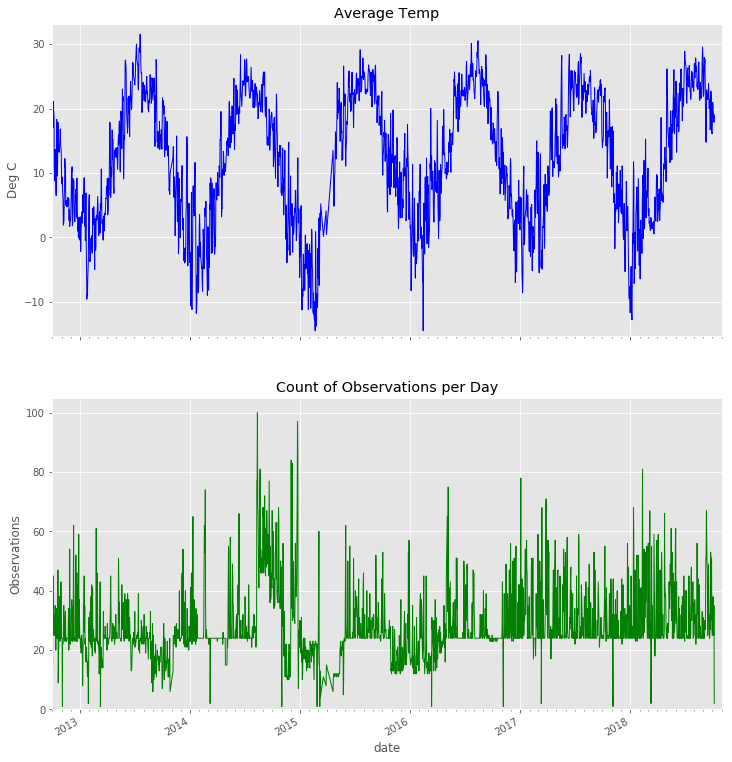

In [82]:
import hw3module as hw3
x=weather_vis_pandas.index
xlabel='date'
y1=weather_vis_pandas['avg(temp)']
y2= weather_vis_pandas['count(datetime)']
title1='Average Temp'
title2='Count of Observations per Day'
y1label='Deg C'
y2label='Observations'
filename="weather_vis_OLD"
figurepath = pathFigure
figsaveformat = 'csv'
colors = ['blue','green','red']
lw_default = 1

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
days = mdates.DayLocator()  # every day
yearsFmt = mdates.DateFormatter('%Y')
monthsFmt = mdates.DateFormatter('%m-%Y')
daysFmt = mdates.DateFormatter('%d')
#hw3.lplotter(x,y1,y2,title1,title2,xlabel,y1label,y2label, filename, figurepath, figuresaveformat)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 14))

def ytickformat(x): 
    return '$%1.2f' % x

# round to nearest month...
datemin = np.datetime64(x[0], 'M')
#datemin = np.datetime64('2016-01-01', 'M')

datemax = np.datetime64(x[-1], 'M') + np.timedelta64(1, 'M')

# plot y1
axes[0].plot(x,y1,linewidth =lw_default, color = colors[0], alpha = 1)
axes[0].set_title(title1)

# plot y2
axes[1].plot(x,y2,linewidth=lw_default ,color = colors[1], alpha = 1)

axes[1].set_title(title2)

axes[0].set_ylabel(y1label)
axes[1].set_ylabel(y2label)
axes[0].set_ylim(np.min(y1)*1.05, np.max(y1)*1.05)
axes[1].set_ylim(0, np.max(y2)*1.05)

# x and y labesls
for ax in axes:
    ax.set_xlabel(xlabel)
    ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
    ax.format_ydata = ytickformat
    ax.grid(True)
    # format the ticks
    #ax.xaxis.set_major_locator(months)
    #ax.xaxis.set_major_formatter(monthsFmt)
    #ax.xaxis.set_minor_locator(days)
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(yearsFmt)
    ax.xaxis.set_minor_locator(months)
    ax.set_xlim(datemin, datemax)

# rotates and right aligns the x labels, and moves the bottom of the
# axes up to make room for them
fig.autofmt_xdate()

#save figure as PNG
figfilename = figurepath+filename+figsaveformat
plt.savefig(figfilename, bbox_inches='tight', dpi = (300))
plt.show()